<a href="https://colab.research.google.com/github/bhuvighosh3/Load-Forecasting/blob/main/Load_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Approach for Load Forecasting and Missing Value Imputation**

## **Task 1: Short-Term Load Forecasting**
- **Goal:** Predict the electricity load for **December 14, 2020**, at 15-minute intervals.
- **Approach:**
  1. **Data Preprocessing:**
     - Convert `datetime` to a proper time format and set it as the index.
     - Handle missing values in weather-related features.
     - Extract time-based features like **hour, day of the week**.
     - Create **lag features and rolling averages** to capture historical trends.
  2. **Checking Stationarity:**
     - Perform an **ADF test** to check if `load` is stationary.
     - Use **ACF and PACF plots** to determine the autoregressive (AR) and moving average (MA) components.
  3. **Model Selection:**
     - **ARIMA** if the data is stationary and does not require exogenous variables.
     - **SARIMAX** if external factors like weather significantly impact `load`.
     - **Prophet** to capture trends, seasonality, and external regressors.
  4. **Forecasting:**
     - Train the selected model on historical data up to **December 13, 2020**.
     - Generate forecasts for December 14, 2020.
     - Evaluate the model using **Mean Absolute Percentage Error (MAPE)**.

## **Task 2: Imputing Missing Load Values**
- **Goal:** Predict and fill missing `load` values in the dataset.
- **Approach:**
  1. **Identifying Missing Values:**
     - Locate all timestamps where `load` is NaN.
  2. **Using ARIMA for Imputation:**
     - Train an **ARIMA model** on available `load` values.
     - Forecast missing `load` values based on historical trends.
  3. **Using ARIMA with Exogenous Variables:**
     - Incorporate weather variables and holiday indicators as external regressors.
     - Align indices between `load` and exogenous variables.
     - Use forward and backward filling to handle missing values in exogenous variables.
  4. **Filling Missing Values:**
     - Replace NaNs in `load` with the predicted values from ARIMA/ARIMA with Exogeneous Variables.


# Loading and Pre-processing data:

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
df=pd.read_csv('/content/assignment-data.csv')

In [ ]:
df.head()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
0,0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
1,1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2,2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
3,3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
4,4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01


In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.columns

Index(['datetime', 'load', 'apparent_temperature', 'temperature', 'humidity',
       'dew_point', 'wind_speed', 'cloud_cover', 'date'],
      dtype='object')

### Handle datetime:

Ensuring it is in proper datetime format and set it as the index for easy manipulation.
Extracting relevant time-based features like hour, day_of_week, and is_weekend.


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df.set_index('datetime', inplace=True)

In [ ]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
weather_columns = ['apparent_temperature', 'temperature', 'humidity',
                   'dew_point', 'wind_speed', 'cloud_cover']
weather_imputer = SimpleImputer(strategy='median')
df[weather_columns] = weather_imputer.fit_transform(df[weather_columns]) #Weather data may have missing values. Using median instead of mean prevents extreme values from distorting predictions.


In [ ]:
df['load'] = df['load'].interpolate(method='time') #Since load is a time series, using time-based interpolation estimates missing values based on trends.


In [ ]:
for lag in range(1, 4):
    df[f'load_lag{lag}'] = df['load'].shift(lag) #Past electricity demand strongly influences future demand. Lagged features help the model understand patterns.

In [ ]:
df['load_roll_1h'] = df['load'].rolling(window=4).mean()
df['load_roll_6h'] = df['load'].rolling(window=24).mean()

In [ ]:
df = df.dropna()

In [ ]:
'''
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['load', 'load_lag1', 'load_lag2', 'load_lag3',
                                           'load_roll_1h', 'load_roll_6h'] + weather_columns])
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=[
    'load', 'load_lag1', 'load_lag2', 'load_lag3', 'load_roll_1h', 'load_roll_6h'] + weather_columns)
'''

In [ ]:
final_df = pd.concat([df, df[['hour', 'day_of_week', 'is_weekend', 'load']]], axis=1)

In [ ]:
train_df = final_df.loc[:"2020-12-13"]

In [ ]:
final_df

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date,hour,day_of_week,is_weekend,load_lag1,load_lag2,load_lag3,load_roll_1h,load_roll_6h,hour,day_of_week,is_weekend,load
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:45:00,843.64896,7.25025,7.373625,1.023750,6.95625,0.359625,0.00000,2018-01-01,5,0,0,822.30463,778.05350,738.09083,795.524480,698.541166,5,0,0,843.64896
2018-01-01 06:00:00,894.71759,7.10850,7.108500,1.029000,6.76200,0.010500,0.00000,2018-01-01,6,0,0,843.64896,822.30463,778.05350,834.681170,702.353453,6,0,0,894.71759
2018-01-01 06:15:00,970.66050,7.34125,7.341250,1.028125,6.98425,0.011375,0.00000,2018-01-01,6,0,0,894.71759,843.64896,822.30463,882.832920,710.510339,6,0,0,970.66050
2018-01-01 06:30:00,1036.12870,7.57400,7.574000,1.027250,7.20650,0.012250,0.00000,2018-01-01,6,0,0,970.66050,894.71759,843.64896,936.288937,723.204482,6,0,0,1036.12870
2018-01-01 06:45:00,1105.67730,7.80675,7.806750,1.026375,7.42875,0.013125,0.00000,2018-01-01,6,0,0,1036.12870,970.66050,894.71759,1001.796023,739.526924,6,0,0,1105.67730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-12 22:45:00,858.50000,17.79750,17.797500,0.756000,12.40050,1.950375,0.16275,2020-12-12,22,5,1,896.88000,934.25000,951.42000,910.262500,1134.876400,22,5,1,858.50000
2020-12-12 23:00:00,832.24000,17.66100,17.661000,0.756000,12.26400,2.047500,0.14700,2020-12-12,23,5,1,858.50000,896.88000,934.25000,880.467500,1120.345867,23,5,1,832.24000
2020-12-12 23:15:00,804.97000,17.46675,17.466750,0.758625,12.12750,2.144625,0.11550,2020-12-12,23,5,1,832.24000,858.50000,896.88000,848.147500,1104.035208,23,5,1,804.97000


In [ ]:
target_date = pd.to_datetime('2020-12-14') #Checking if target date exists in the data.
print(target_date in final_df['date'])

False


### Checking Stationarity with ADF Test
If p-value < 0.05, the data is stationary, meaning it does not have a trend.

If p-value > 0.05, the data is non-stationary, meaning it has trends and needs differencing.


In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['load'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Statistic: -5.771080515127137
P-value: 5.390540518621483e-07


**ADF Test:**
Stationarity is crucial for time series modeling.Machine learning models (e.g., ARIMA) assume stationarity. A non-stationary series has a changing mean, variance, or autocorrelation over time, making predictions unreliable. More negative values indicate stronger stationarity. Helps decide if differencing is needed.


**P-value:**
Since this p-value is much smaller than 0.05, we reject the null hypothesis, meaning the time series is stationary & ARIMA & its variants can be used.

### Checking Seasonality in the data:

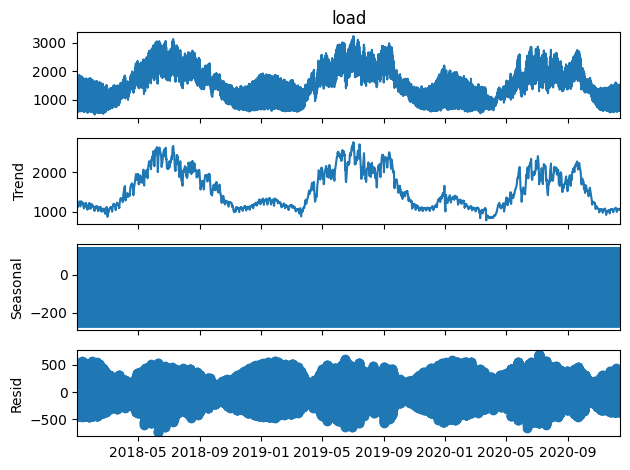

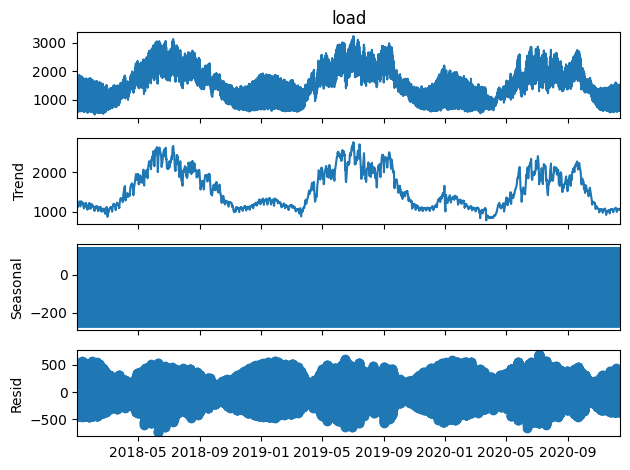

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['load'], model='additive', period=96)
decomposition.plot()

**Trend Component (Second Plot):**
There is a clear upward and downward trend over time, indicating long-term variations in the data.
This suggests the presence of a non-stationary component in the series.

**Seasonal Component (Third Plot):**
The seasonal plot appears flat, meaning the decomposition failed to capture a seasonal pattern.This is because the data is not seasonal.
Since there is no pattern observed, we can conclude that the data is not seasonal. Hence, ARIMA & its variants can be used for this.

**Residuals (Fourth Plot):**
The residuals appear heteroskedastic (changing variance over time), meaning there could be unexplained variability in the model.


### Checking the final df while will be used in the model architecture.

In [ ]:
final_df.columns

Index(['load', 'apparent_temperature', 'temperature', 'humidity', 'dew_point',
       'wind_speed', 'cloud_cover', 'date', 'hour', 'day_of_week',
       'is_weekend', 'load_lag1', 'load_lag2', 'load_lag3', 'load_roll_1h',
       'load_roll_6h', 'hour', 'day_of_week', 'is_weekend', 'load'],
      dtype='object')

In [ ]:
final_df.head()

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date,hour,day_of_week,is_weekend,load_lag1,load_lag2,load_lag3,load_roll_1h,load_roll_6h,hour,day_of_week,is_weekend,load
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:45:00,843.64896,7.25025,7.373625,1.023750,6.95625,0.359625,0.0,2018-01-01,5,0,0,822.30463,778.05350,738.09083,795.524480,698.541166,5,0,0,843.64896
2018-01-01 06:00:00,894.71759,7.10850,7.108500,1.029000,6.76200,0.010500,0.0,2018-01-01,6,0,0,843.64896,822.30463,778.05350,834.681170,702.353453,6,0,0,894.71759
2018-01-01 06:15:00,970.66050,7.34125,7.341250,1.028125,6.98425,0.011375,0.0,2018-01-01,6,0,0,894.71759,843.64896,822.30463,882.832920,710.510339,6,0,0,970.66050
2018-01-01 06:30:00,1036.12870,7.57400,7.574000,1.027250,7.20650,0.012250,0.0,2018-01-01,6,0,0,970.66050,894.71759,843.64896,936.288937,723.204482,6,0,0,1036.12870
2018-01-01 06:45:00,1105.67730,7.80675,7.806750,1.026375,7.42875,0.013125,0.0,2018-01-01,6,0,0,1036.12870,970.66050,894.71759,1001.796023,739.526924,6,0,0,1105.67730


## Using ACF & PACF plots before using ARIMA:

#### 1. Why ACF (Autocorrelation Function) is Used?
ACF measures the correlation between a time series and its lagged values over different time steps. It helps in identifying:
- The **moving average (MA) component** by showing how past observations influence the current observation.
- The **p-value selection for ARIMA**, as a significant ACF cutoff indicates an MA process.

#### 2. Why PACF (Partial Autocorrelation Function) is Used?
PACF removes the effects of intermediate lags when measuring correlation. It helps in:
- Identifying the **autoregressive (AR) component** by showing direct relationships with past values.
- Selecting the **order (p) in ARIMA**, as the PACF cutoff suggests the number of lag terms to use.

#### 3. How to Use ACF and PACF for ARIMA Selection?
- A sharp cutoff in **ACF** and gradual decay in **PACF** → AR model (choose p from PACF).
- A sharp cutoff in **PACF** and gradual decay in **ACF** → MA model (choose q from ACF).
- Both **ACF and PACF decay slowly** → ARMA or ARIMA model needed.


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
train_load = train_df['load'].iloc[:,0]

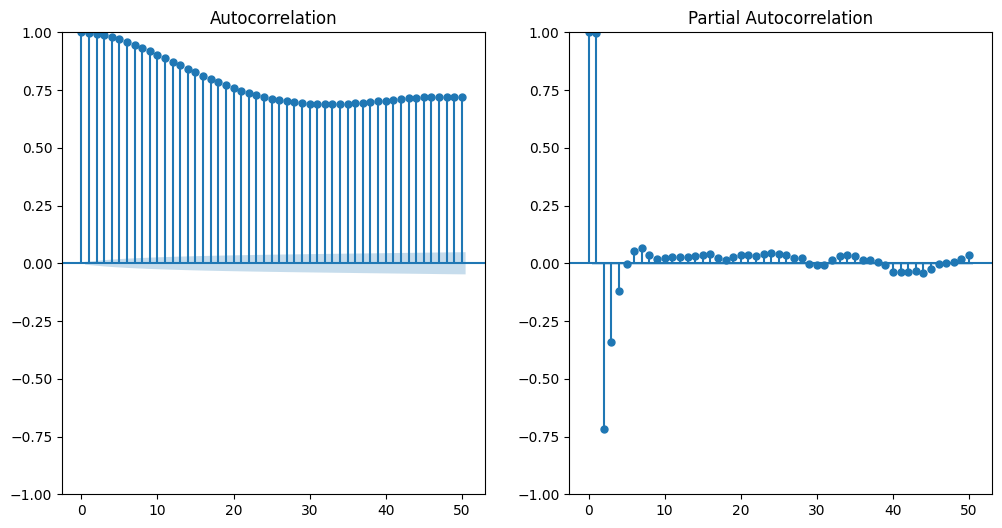

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_load, lags=50, ax=plt.gca())
plt.subplot(122)
plot_pacf(train_load, lags=50, ax=plt.gca())
plt.show()

# Implementing Univariate ARIMA to predict the load:

### Selecting the best configuration for ARIMA according to AIC:

The Akaike Information Criterion (AIC) is a key metric for selecting the best ARIMA model. It balances model complexity and goodness of fit—lower AIC values indicate better models.

Steps to Select the Best ARIMA Parameters (p, d, q) Using AIC
Determine d (Order of Differencing):

*   Use the ADF test (Augmented Dickey-Fuller) to check stationarity.
If the series is non-stationary (p-value > 0.05), apply differencing (d=1 or more) until the series becomes stationary.


Grid Search Over p and q:


*   Try different values of p (AR terms) and q (MA terms).
*   Fit ARIMA models with various (p, d, q) combinations.

*   Calculate AIC for each model.
*   Choose the Model with the Lowest AIC. The model with the lowest AIC is the best trade-off between fit and complexity.






In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def get_best_arima(train_data):
    best_aic = np.inf
    best_order = None
    best_model = None
    for p in range(4):
        for d in range(1): # 1 since the data is stationary.
            for q in range(3):
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except:
                    continue
    return best_model, best_order

best_model, best_order = get_best_arima(train_load)

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_model.aic}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  

Best ARIMA order: (2, 1, 2)
Best AIC: -391995.7883789996


In [ ]:
train_load

,load
datetime,
2018-01-01 05:45:00,843.64896
2018-01-01 06:00:00,894.71759
2018-01-01 06:15:00,970.66050
2018-01-01 06:30:00,1036.12870
2018-01-01 06:45:00,1105.67730
...,...
2020-12-12 22:45:00,858.50000
2020-12-12 23:00:00,832.24000
2020-12-12 23:15:00,804.97000


### Implementing best ARIMA configuration obtained from above:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
train_load = train_df['load'].iloc[:,1]
p, d, q = 2, 1, 2
model = ARIMA(train_load, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:               103369
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -451085.755
Date:                Thu, 30 Jan 2025   AIC                         902181.510
Time:                        05:20:06   BIC                         902229.240
Sample:                    01-01-2018   HQIC                        902195.974
                         - 12-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9219      0.001   1825.818      0.000       1.920       1.924
ar.L2         -0.9326      0.001   -881.261      0.000      -0.935      -0.931
ma.L1         -1.4842      0.002   -753.918      0.0

In [ ]:
forecast = model_fit.forecast(steps=192)

### Forecasted values for December 14.

In [ ]:
forecast.tail(96)

,predicted_mean
2020-12-14 00:00:00,1065.264528
2020-12-14 00:15:00,1065.724897
2020-12-14 00:30:00,1066.013226
2020-12-14 00:45:00,1066.138045
2020-12-14 01:00:00,1066.109050
...,...
2020-12-14 22:45:00,1052.150194
2020-12-14 23:00:00,1052.105519
2020-12-14 23:15:00,1052.067742
2020-12-14 23:30:00,1052.036801


In [ ]:
forecast.tail(96).to_csv('Forecasted_values_14Dec_ARIMA.csv')

### Variation in load on 24 December:

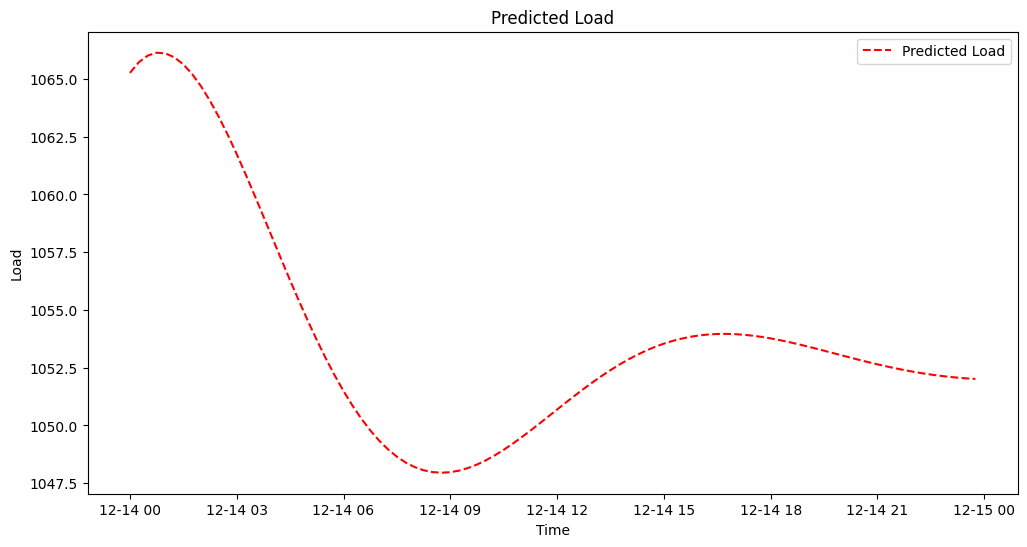

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(forecast[-96:], label='Predicted Load', color='red', linestyle='--')
plt.title('Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

### Previous vs Predicted Load (Includes till 14 December)

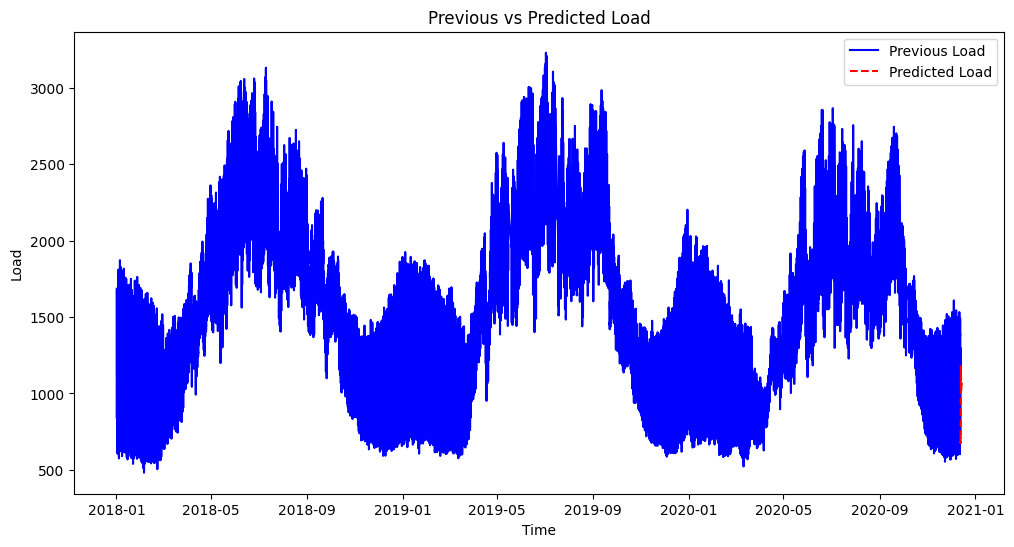

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(final_df['load'].iloc[:,0], label='Previous Load', color='blue')
plt.plot(forecast, label='Predicted Load', color='red', linestyle='--')
plt.title('Previous vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

# Implementing ARIMA with Exogeneous Variables to predict the load:

## Check holidays: Using the holidays Library

The holidays library in Python provides holiday dates for various countries. It can be used to generate holiday dates for a given year and country, then check if the dates in the dataset match any of those.

In [ ]:
import holidays

In [ ]:
final_df.index = pd.to_datetime(final_df.index) #Since the given dataset has years from 2018 to 2020.

In [ ]:
holiday = holidays.India(years=[2018,2019,2020]) # Retrieving holidays for the years.

In [ ]:
holiday

{datetime.date(2018, 1, 14): 'Makar Sankranti / Pongal', datetime.date(2018, 1, 26): 'Republic Day', datetime.date(2018, 8, 15): 'Independence Day', datetime.date(2018, 10, 2): 'Gandhi Jayanti', datetime.date(2018, 5, 1): 'Labour Day', datetime.date(2018, 11, 7): 'Diwali', datetime.date(2018, 3, 2): 'Holi', datetime.date(2018, 9, 20): 'Day of Ashura (estimated)', datetime.date(2018, 11, 20): 'Mawlid (estimated)', datetime.date(2018, 6, 15): 'Eid ul-Fitr (estimated)', datetime.date(2018, 6, 16): 'Eid ul-Fitr (estimated)', datetime.date(2018, 8, 21): 'Eid al-Adha (estimated)', datetime.date(2018, 8, 22): 'Eid al-Adha (estimated)', datetime.date(2018, 3, 25): 'Palm Sunday', datetime.date(2018, 3, 30): 'Good Friday', datetime.date(2018, 4, 1): 'Easter Sunday', datetime.date(2018, 5, 20): 'Feast of Pentecost', datetime.date(2018, 12, 25): 'Christmas Day', datetime.date(2019, 1, 14): 'Makar Sankranti / Pongal', datetime.date(2019, 1, 26): 'Republic Day', datetime.date(2019, 8, 15): 'Independ

In [ ]:
holiday_dates = [f"{date.day:02d}-{date.month:02d}-{date.year}" for date in holiday.keys()]

In [ ]:
holiday_dates

['14-01-2018',
 '26-01-2018',
 '15-08-2018',
 '02-10-2018',
 '01-05-2018',
 '07-11-2018',
 '02-03-2018',
 '20-09-2018',
 '20-11-2018',
 '15-06-2018',
 '16-06-2018',
 '21-08-2018',
 '22-08-2018',
 '25-03-2018',
 '30-03-2018',
 '01-04-2018',
 '20-05-2018',
 '25-12-2018',
 '14-01-2019',
 '26-01-2019',
 '15-08-2019',
 '02-10-2019',
 '01-05-2019',
 '27-10-2019',
 '21-03-2019',
 '09-09-2019',
 '09-11-2019',
 '04-06-2019',
 '05-06-2019',
 '11-08-2019',
 '12-08-2019',
 '14-04-2019',
 '19-04-2019',
 '21-04-2019',
 '09-06-2019',
 '25-12-2019',
 '14-01-2020',
 '26-01-2020',
 '15-08-2020',
 '02-10-2020',
 '01-05-2020',
 '14-11-2020',
 '10-03-2020',
 '29-08-2020',
 '29-10-2020',
 '24-05-2020',
 '25-05-2020',
 '31-07-2020',
 '01-08-2020',
 '05-04-2020',
 '10-04-2020',
 '12-04-2020',
 '31-05-2020',
 '25-12-2020']

In [ ]:
index_dates = final_df.index.strftime('%d-%m-%Y')

In [ ]:
final_df

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date,hour,day_of_week,is_weekend,load_lag1,load_lag2,load_lag3,load_roll_1h,load_roll_6h,hour,day_of_week,is_weekend,load
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:45:00,843.64896,7.25025,7.373625,1.023750,6.95625,0.359625,0.00000,2018-01-01,5,0,0,822.30463,778.05350,738.09083,795.524480,698.541166,5,0,0,843.64896
2018-01-01 06:00:00,894.71759,7.10850,7.108500,1.029000,6.76200,0.010500,0.00000,2018-01-01,6,0,0,843.64896,822.30463,778.05350,834.681170,702.353453,6,0,0,894.71759
2018-01-01 06:15:00,970.66050,7.34125,7.341250,1.028125,6.98425,0.011375,0.00000,2018-01-01,6,0,0,894.71759,843.64896,822.30463,882.832920,710.510339,6,0,0,970.66050
2018-01-01 06:30:00,1036.12870,7.57400,7.574000,1.027250,7.20650,0.012250,0.00000,2018-01-01,6,0,0,970.66050,894.71759,843.64896,936.288937,723.204482,6,0,0,1036.12870
2018-01-01 06:45:00,1105.67730,7.80675,7.806750,1.026375,7.42875,0.013125,0.00000,2018-01-01,6,0,0,1036.12870,970.66050,894.71759,1001.796023,739.526924,6,0,0,1105.67730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-12 22:45:00,858.50000,17.79750,17.797500,0.756000,12.40050,1.950375,0.16275,2020-12-12,22,5,1,896.88000,934.25000,951.42000,910.262500,1134.876400,22,5,1,858.50000
2020-12-12 23:00:00,832.24000,17.66100,17.661000,0.756000,12.26400,2.047500,0.14700,2020-12-12,23,5,1,858.50000,896.88000,934.25000,880.467500,1120.345867,23,5,1,832.24000
2020-12-12 23:15:00,804.97000,17.46675,17.466750,0.758625,12.12750,2.144625,0.11550,2020-12-12,23,5,1,832.24000,858.50000,896.88000,848.147500,1104.035208,23,5,1,804.97000


In [ ]:
final_df['Is_Holiday'] = index_dates.isin(holiday_dates) # Mapping the given dataset to the holidays to understand the impact of holidays on load.

In [ ]:
final_df['Is_Holiday'].value_counts()

,count
Is_Holiday,
False,98281
True,5088


In [ ]:
final_df['Is_Holiday'] = final_df['Is_Holiday'].apply(lambda x: 1 if x is True else 0)

In [ ]:
final_df

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date,hour,day_of_week,...,load_lag1,load_lag2,load_lag3,load_roll_1h,load_roll_6h,hour,day_of_week,is_weekend,load,Is_Holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 05:45:00,843.64896,7.25025,7.373625,1.023750,6.95625,0.359625,0.00000,2018-01-01,5,0,...,822.30463,778.05350,738.09083,795.524480,698.541166,5,0,0,843.64896,0
2018-01-01 06:00:00,894.71759,7.10850,7.108500,1.029000,6.76200,0.010500,0.00000,2018-01-01,6,0,...,843.64896,822.30463,778.05350,834.681170,702.353453,6,0,0,894.71759,0
2018-01-01 06:15:00,970.66050,7.34125,7.341250,1.028125,6.98425,0.011375,0.00000,2018-01-01,6,0,...,894.71759,843.64896,822.30463,882.832920,710.510339,6,0,0,970.66050,0
2018-01-01 06:30:00,1036.12870,7.57400,7.574000,1.027250,7.20650,0.012250,0.00000,2018-01-01,6,0,...,970.66050,894.71759,843.64896,936.288937,723.204482,6,0,0,1036.12870,0
2018-01-01 06:45:00,1105.67730,7.80675,7.806750,1.026375,7.42875,0.013125,0.00000,2018-01-01,6,0,...,1036.12870,970.66050,894.71759,1001.796023,739.526924,6,0,0,1105.67730,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-12 22:45:00,858.50000,17.79750,17.797500,0.756000,12.40050,1.950375,0.16275,2020-12-12,22,5,...,896.88000,934.25000,951.42000,910.262500,1134.876400,22,5,1,858.50000,0
2020-12-12 23:00:00,832.24000,17.66100,17.661000,0.756000,12.26400,2.047500,0.14700,2020-12-12,23,5,...,858.50000,896.88000,934.25000,880.467500,1120.345867,23,5,1,832.24000,0
2020-12-12 23:15:00,804.97000,17.46675,17.466750,0.758625,12.12750,2.144625,0.11550,2020-12-12,23,5,...,832.24000,858.50000,896.88000,848.147500,1104.035208,23,5,1,804.97000,0


In [ ]:
final_df.columns

Index(['load', 'apparent_temperature', 'temperature', 'humidity', 'dew_point',
       'wind_speed', 'cloud_cover', 'date', 'hour', 'day_of_week',
       'is_weekend', 'load_lag1', 'load_lag2', 'load_lag3', 'load_roll_1h',
       'load_roll_6h', 'hour', 'day_of_week', 'is_weekend', 'load',
       'Is_Holiday'],
      dtype='object')

In [ ]:
final_df_cleaned = final_df.replace([np.inf, -np.inf], np.nan).dropna() #The preprocessed dataset with an additional column that indicates if a particular day is a holiday or not.

### ARIMA with exogeneous variables to include factors that might affect load:
Exogeneous factors include humidity, cloud cover, temperature, dew point (Since these factors affect rainfall) & the occurance of a holiday.

In [ ]:
exog = final_df_cleaned[['humidity', 'cloud_cover', 'temperature', 'dew_point', 'wind_speed', 'Is_Holiday']]

In [ ]:
model = ARIMA(final_df_cleaned['load'].iloc[:,0], exog=exog, order=(p, d, q))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


In [ ]:
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast= model_fit.forecast(steps=192, exog=exog[-192:]) # Predicting 192 steps which include 13 and 14 December.
print(forecast.tail(96)) #Displaying only for 14 December.

2020-12-14 00:00:00    1058.751765
2020-12-14 00:15:00    1058.437239
2020-12-14 00:30:00    1057.954216
2020-12-14 00:45:00    1057.314707
2020-12-14 01:00:00    1056.531654
                          ...     
2020-12-14 22:45:00    1039.271158
2020-12-14 23:00:00    1038.497600
2020-12-14 23:15:00    1037.286900
2020-12-14 23:30:00    1036.083540
2020-12-14 23:45:00    1034.887076
Freq: 15min, Name: predicted_mean, Length: 96, dtype: float64


In [ ]:
forecast.tail(96).to_csv('Forecasted_values_14Dec_ARIMA_EXOGENEOUS_VARIABLES.csv')

### Variation in load on 24 December:

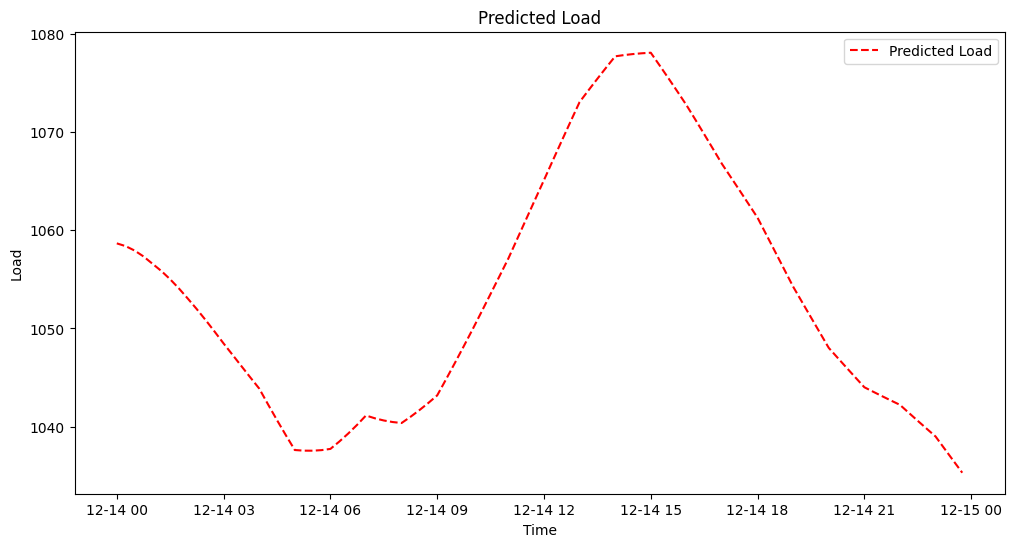

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(forecast[-96:], label='Predicted Load', color='red', linestyle='--')
plt.title('Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

### Previous vs Predicted Load (Includes till 14 December)

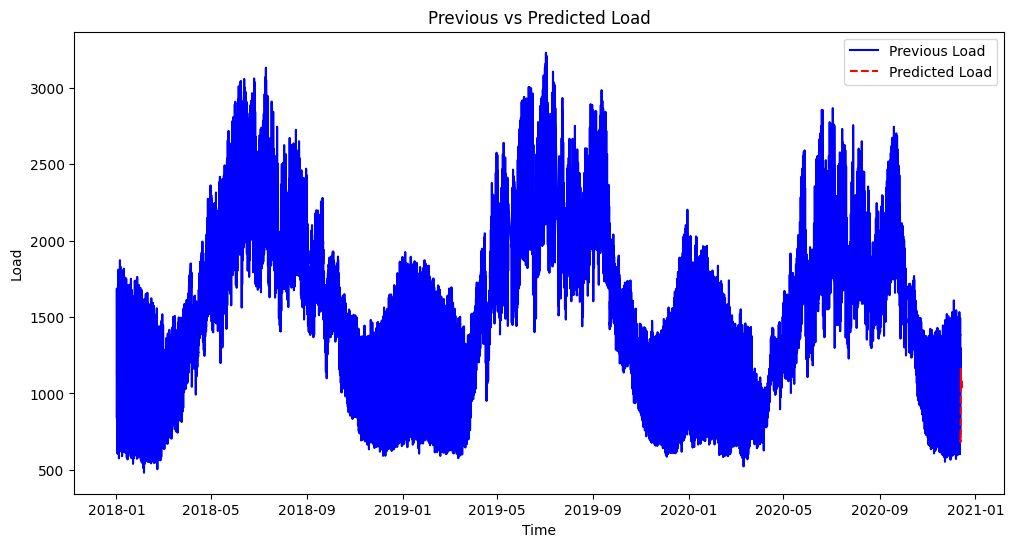

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(final_df['load'].iloc[:,0], label='Previous Load', color='blue')
plt.plot(forecast, label='Predicted Load', color='red', linestyle='--')
plt.title('Previous vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

# Predicting missing values:


In [ ]:
df1=pd.read_csv('/content/assignment-data.csv')
df1.drop(columns=['Unnamed: 0'], inplace=True)
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1 = df1.sort_values('datetime')
df1.set_index('datetime', inplace=True)
df1['hour'] = df1.index.hour
df1['day_of_week'] = df1.index.dayofweek
train_df1 = df1.dropna(subset=['load'])
test_df1 = df1[df1['load'].isna()]

In [ ]:
test_df1

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date,hour,day_of_week
datetime,,,,,,,,,,
2019-05-16 00:00:00,NaN,31.458000,31.458000,0.441000,16.56900,0.136500,0.4620,2019-05-16,0,3
2019-05-16 00:15:00,NaN,31.371375,31.371375,0.443625,16.55325,0.168000,0.4620,2019-05-16,0,3
2019-05-16 00:30:00,NaN,31.284750,31.284750,0.446250,16.53750,0.199500,0.4620,2019-05-16,0,3
2019-05-16 00:45:00,NaN,31.198125,31.198125,0.448875,16.52175,0.231000,0.4620,2019-05-16,0,3
2019-05-16 01:00:00,NaN,31.111500,31.111500,0.451500,16.50600,0.262500,0.4620,2019-05-16,1,3
...,...,...,...,...,...,...,...,...,...,...
2020-10-07 22:45:00,NaN,27.586125,27.586125,0.433125,12.66825,1.346625,0.1785,2020-10-07,22,2
2020-10-07 23:00:00,NaN,27.384000,27.384000,0.441000,12.81000,1.239000,0.1680,2020-10-07,23,2
2020-10-07 23:15:00,NaN,29.662500,28.612500,0.304500,12.02250,1.050000,0.0105,2020-10-07,23,2


### Using ARIMA:

In [ ]:
train_load1 = train_df1['load']
p, d, q = 2, 1, 2
model1 = ARIMA(train_load, order=(p, d, q))
model_fit1 = model1.fit()
print(model_fit1.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:               103296
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -462423.453
Date:                Thu, 30 Jan 2025   AIC                         924856.906
Time:                        06:42:05   BIC                         924904.632
Sample:                    01-01-2018   HQIC                        924871.368
                         - 12-11-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9191      0.001   2120.194      0.000       1.917       1.921
ar.L2         -0.9297      0.001  -1017.487      0.000      -0.931      -0.928
ma.L1         -1.5264      0.001  -1564.950      0.0

### Exporting forecasted values for missing loads using ARIMA:

In [ ]:
# Create an empty list to store the forecasted values
forecast_values1 = []

# Loop over each timestamp in test_df1.index and predict the value for that timestamp
for timestamp in test_df1.index:
    # Predict for the given timestamp
    forecast_value = model_fit1.predict(start=timestamp, end=timestamp)
    forecast_values1.append(forecast_value[0])  # Append the predicted value (first element)

# Convert the forecasted values to a DataFrame
forecast_df1 = pd.DataFrame(forecast_values1, index=test_df1.index, columns=['predicted_load'])

<ipython-input-167-b37a0d5e35d3>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_values1.append(forecast_value[0])  # Append the predicted value (first element)


In [ ]:
len(forecast_df1) #Checking if all missing values have been forecasted

1440

In [ ]:
forecast_df1.to_csv('Predicted Missing Values_ARIMA.csv')

### Using ARIMA with Exogeneous Variables:

In [ ]:
index_dates = df1.index.strftime('%d-%m-%Y')
df1['Is_Holiday'] = index_dates.isin(holiday_dates) # Mapping the given dataset to the holidays to understand the impact of holidays on load.
df1['Is_Holiday'] = df1['Is_Holiday'].apply(lambda x: 1 if x is True else 0)
exog = df1[['humidity', 'cloud_cover', 'temperature', 'dew_point', 'wind_speed', 'Is_Holiday']]
exog = exog.fillna(method='ffill').fillna(method='bfill')
exog = exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
exog = exog.loc[train_load1.index]
model2 = ARIMA(train_load1, exog=exog, order=(p, d, q))
model_fit2 = model2.fit()
print(model_fit2.summary())

<ipython-input-143-6455c7c57d15>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = exog.fillna(method='ffill').fillna(method='bfill')
<ipython-input-143-6455c7c57d15>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:               101952
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -446813.452
Date:                Thu, 30 Jan 2025   AIC                         893648.904
Time:                        06:57:57   BIC                         893753.759
Sample:                             0   HQIC                        893680.697
                             - 101952                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity      -19.4339      5.928     -3.278      0.001     -31.053      -7.815
cloud_cover    13.9161      1.356     10.265      0.000      11.259      16.573
temperature     4.5227      0.222     20.410    

### Exporting forecasted values for missing loads using ARIMA with Exogeneous Variables:

In [ ]:
exog = df1[['humidity', 'cloud_cover', 'temperature', 'dew_point', 'wind_speed', 'Is_Holiday']]
exog = exog.fillna(method='ffill').fillna(method='bfill')
exog = exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
exog_test = exog.loc[test_df1.index]
forecast_values2 = []

# Loop through each timestamp in the test dataframe index
for timestamp in test_df1.index:
    # Select the corresponding exogenous variables for the current timestamp
    exog_current = exog_test.loc[exog_test.index == timestamp]

    # Predict the load for the current timestamp (no need for start and end)
    forecast_value = model_fit2.predict(exog=exog_current)

    # Append the forecast value along with the timestamp
    forecast_values2.append([timestamp, forecast_value[0]])

<ipython-input-158-d242df3438dc>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = exog.fillna(method='ffill').fillna(method='bfill')
<ipython-input-158-d242df3438dc>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
<ipython-input-158-d242df3438dc>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_values2.append([timestamp, forecast_value[0]])


In [ ]:
forecast_df2 = pd.DataFrame(forecast_values2, columns=['datetime', 'predicted_load'])

In [ ]:
len(forecast_df2) #Checking if all forecast values have been predicted.

1440

In [ ]:
forecast_df2.to_csv('Predicted Missing Values_ARIMA_EXOGENEOUS_VARIABLES.csv')

In [ ]:
forecast_df2['datetime'] = pd.to_datetime(forecast_df2['datetime']) #Imputing the values
forecast_df2.set_index('datetime', inplace=True)
df1.loc[df1['load'].isna(), 'load'] = forecast_df2.loc[df1[df1['load'].isna()].index, 'predicted_load']

# Evaluation:

Checking MAPE for 12 December 2020 (Since we have the actual values for 12 December, we can compare it easily).

In [ ]:
train_df = df1.loc[:'2020-12-11']
test_df = df1.loc['2020-12-12']

train_load = train_df['load']
test_load = test_df['load']

In [ ]:
#ARIMA:
from sklearn.metrics import mean_absolute_percentage_error as mape
p, d, q = 2, 1, 2
arima_model = ARIMA(train_load, order=(p, d, q))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_load))
arima_forecast.index = test_load.index
arima_mape = mape(test_load, arima_forecast)
print(f"ARIMA MAPE: {arima_mape:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


ARIMA MAPE: 0.18


Since the MAPE is less than 20%, it is considered to be a good forecasting model.

# Exporting files in required format:

In [ ]:
f1=pd.read_csv('/content/Forecasted_values_14Dec_ARIMA.csv')
f2=pd.read_csv('/content/Forecasted_values_14Dec_ARIMA_EXOGENEOUS_VARIABLES.csv')
f3=pd.read_csv('/content/Predicted Missing Values_ARIMA.csv')
f4=pd.read_csv('/content/Predicted Missing Values_ARIMA_EXOGENEOUS_VARIABLES.csv')

In [ ]:
f4.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
f1['datetime'] = pd.to_datetime(f1['Unnamed: 0'])
f2['datetime'] = pd.to_datetime(f2['Unnamed: 0'])

f1 = f1.sort_values(by='datetime')
f2 = f2.sort_values(by='datetime')
f3 = f3.sort_values(by='datetime')
f4 = f4.sort_values(by='datetime')

f1.rename(columns={f1.columns[1]: 'forecast'}, inplace=True)
f2.rename(columns={f2.columns[1]: 'forecast'}, inplace=True)
f3.rename(columns={f3.columns[1]: 'forecast'}, inplace=True)
f4.rename(columns={f4.columns[1]: 'forecast'}, inplace=True)

f1.drop(columns=['Unnamed: 0'], inplace=True)
f2.drop(columns=['Unnamed: 0'], inplace=True)

f1.reset_index(drop=True, inplace=True)
f2.reset_index(drop=True, inplace=True)
f3.reset_index(drop=True, inplace=True)
f4.reset_index(drop=True, inplace=True)

             datetime     forecast
0 2020-12-14 00:00:00  1065.264528
1 2020-12-14 00:15:00  1065.724897
2 2020-12-14 00:30:00  1066.013226
3 2020-12-14 00:45:00  1066.138045
4 2020-12-14 01:00:00  1066.109050
             datetime     forecast
0 2020-12-14 00:00:00  1058.751765
1 2020-12-14 00:15:00  1058.437239
2 2020-12-14 00:30:00  1057.954216
3 2020-12-14 00:45:00  1057.314707
4 2020-12-14 01:00:00  1056.531654
              datetime     forecast
0  2019-05-16 00:00:00  2199.029909
1  2019-05-16 00:15:00   115.523287
2  2019-05-16 00:30:00   380.999126
3  2019-05-16 00:45:00   522.409967
4  2019-05-16 01:00:00   599.270782
              datetime   forecast
0  2019-05-16 00:00:00  37.892235
1  2019-05-16 00:15:00  37.892235
2  2019-05-16 00:30:00  37.892235
3  2019-05-16 00:45:00  37.892235
4  2019-05-16 01:00:00  37.892235


In [ ]:
f1.to_csv('FORECASTED_VALUES_14_DEC_ARIMA.csv', index=False)
f2.to_csv('FORECASTED_VALUES_14_DEC_ARIMA_WITH_EXOGENOUS_VARIABLES.csv', index=False)
f3.to_csv('PREDICTED_MISSING_VALUES_ARIMA.csv', index=False)
f4.to_csv('PREDICTED_MISSING_VALUES_ARIMA_WITH_EXOGENOUS_VARIABLES.csv', index=False)